**Import modules**

First of all, we need to import all neccessary modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from scipy import stats
import seaborn as sns;
%matplotlib inline
import os
import math as math
import random
import copy

**Read/Analyse Data**

We read the basic data stored in out file (Train.csv).
For this, we use pandas.

In [2]:
np.seterr(all = 'ignore') 
path = os.getcwd() + '/Train.csv'
data = pd.read_csv(path)

We check first several (4 in this case) rows and see what we have

In [3]:
data.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6,A


**Explore Data**

We can remove columns names 'ID' and 'Segmentation', because we don't need that information. But before we remove these columns, let's quickly check if we have duplicated rows, in order to remove extra information.

In [4]:
print(f"Duplicated rows: {data.duplicated().sum()}")

Duplicated rows: 0


Good. There was none. Now we can calmly remove. <br>
Also, copy data (with removed ID and Segmentation, because we don't need them) for later purposes.

In [5]:
data.drop(["ID"], axis = 1, inplace = True)
data.drop(["Segmentation"], axis = 1, inplace = True)
copied_data = copy.deepcopy(data)

Let's quickly check that it was really removed

In [6]:
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
4,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6


So far so good. Now we need to check if there are any missing values in our data. Because K-means clustering can't handle missing values.

In [7]:
print(f"Missing values in each variable: \n{data.isnull().sum()}")

Missing values in each variable: 
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64


Unfortunaltelly, there is missing data. Now we need to handle that.

Investigate patterns in number of missing data ccording to column

In [8]:
data.isnull().sum().describe()

count      9.000000
mean     175.777778
std      266.510215
min        0.000000
25%        0.000000
50%       78.000000
75%      140.000000
max      829.000000
dtype: float64

In [9]:
null_count = np.asarray(data.isnull().sum().tolist())

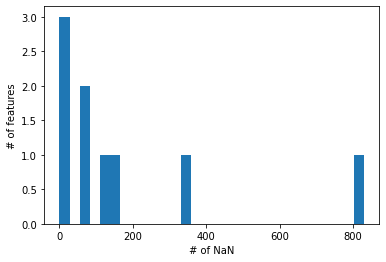

In [10]:
plt.hist(null_count, bins=30)
plt.xlabel("# of NaN")
plt.ylabel('# of features')
plt.show()

Let's investigate and handle each column separately.
1. 'Ever_Married'

<AxesSubplot:xlabel='Age', ylabel='count'>

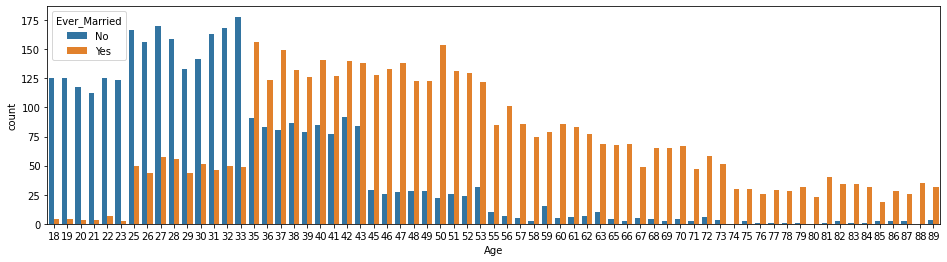

In [11]:
plt.figure(figsize=(16,4))
sns.countplot('Age', hue='Ever_Married', data=data)

It's obvious that age is good metric. Let's see what other parameters 'Ever_married' could be dependant.

<AxesSubplot:xlabel='Graduated', ylabel='count'>

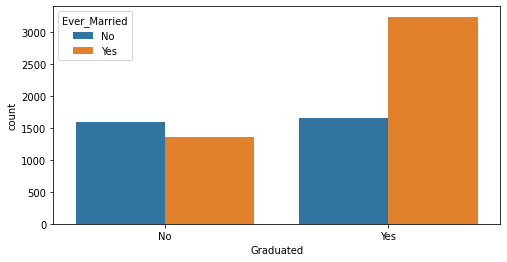

In [12]:
plt.figure(figsize=(8,4))
sns.countplot('Graduated', hue='Ever_Married', data=data)

'Graduated' does not affect 'Ever_married' much, so I will not take it to consideration

<AxesSubplot:xlabel='Profession', ylabel='count'>

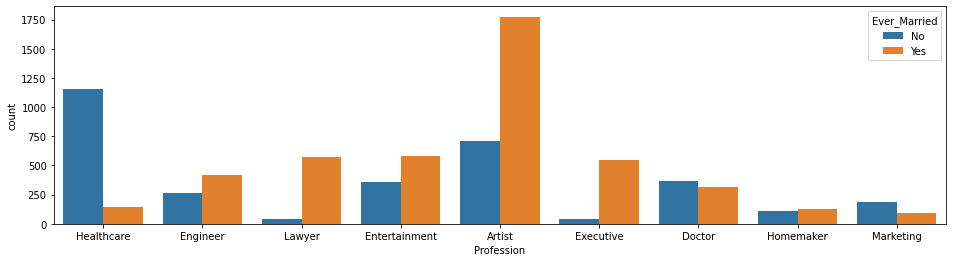

In [13]:
plt.figure(figsize=(16,4))
sns.countplot('Profession', hue='Ever_Married', data=data)

This was strange for me, because I somehow thought that profession was not affecting if one was ever married or not. But this proves me wrong. Turns out in most cases, Artists have been married and healthcare people - have not.

Now, I will try to combine these (Age and Profession) information and update missing values.

In [14]:
ever_married_random = random.uniform(0,1)
# as we can see, people below 25 are rarely married
data.loc[(data['Ever_Married'].isnull()) & (data['Age'] <= 25), ['Ever_Married']] = 'No'

# as we can see, people above 25 and below 35 are married in some cases
# I will choose probability of 0.4 (chance of being married)
data.loc[(data['Ever_Married'].isnull()) & (data['Age'] <= 35)
                                            & (ever_married_random> 0.6),
         ['Ever_Married']] = 'No'

# as we can see, people above 35 and below 45 roughly half of them have been married 
data.loc[(data['Ever_Married'].isnull()) & (data['Age'] <= 35)
                                            & (ever_married_random > 0.5),
         ['Ever_Married']] = 'No'

# as we can see, in most cases artists have been married
data.loc[(data['Ever_Married'].isnull()) & (data['Profession'] == 'Artist'),
         ['Ever_Married']] = 'Yes'

# people above 45 have married at some point in their life
data.loc[(data['Ever_Married'].isnull()) & (data['Age'] > 45), ['Ever_Married']] = 'Yes'
# if I missed any case, this should take care of it
data.loc[(data['Ever_Married'].isnull()), ['Ever_Married']] = 'Yes'

Let's make sure that missing values in 'Ever_Married' have been replaced.

In [15]:
print(f"Missing values in each variable: \n{data.isnull().sum()}")

Missing values in each variable: 
Gender               0
Ever_Married         0
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64


2. 'Graduated'

In [16]:
data['Graduated'].describe()
average_age = math.floor(data['Age'].mean())
data[['Age', 'Graduated']].describe()
below_average = data.loc[(data['Age'] <= average_age), ['Age', 'Graduated']]
above_average = data.loc[(data['Age'] > average_age), ['Age', 'Graduated']]

<AxesSubplot:xlabel='Age', ylabel='count'>

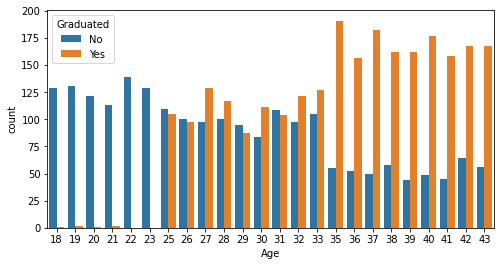

In [17]:
plt.figure(figsize=(8,4))
sns.countplot('Age', hue='Graduated', data=below_average)

<AxesSubplot:xlabel='Age', ylabel='count'>

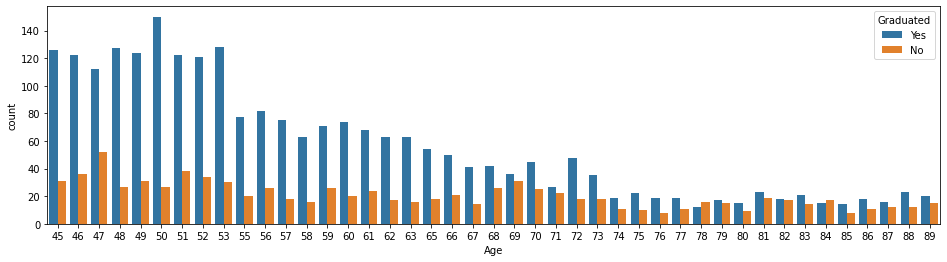

In [18]:
plt.figure(figsize=(16,4))
sns.countplot('Age', hue='Graduated', data=above_average)

We can see 'statistics' of graduated people according to age. Now I will try to fill nan values based on this info.

I divided age in two groups. Below and above avarege. Within this groups I calculate what are possibilities that they graduated or not. Based on this information I later on will update our data by replacing nan values.

In [19]:
below_average_nots = 0
below_averaeg_total = below_average['Age'].count()
for indx, row in below_average.iterrows():
    if row['Graduated'] == 'No':
        below_average_nots += 1

below_average_no_possibility = below_average_nots/below_averaeg_total

above_average_nots = 0
above_averaeg_total = above_average['Age'].count()
for indx, row in above_average.iterrows():
    if row['Graduated'] == 'No':
         above_average_nots += 1
            
above_average_no_possibility = above_average_nots/above_averaeg_total

Update data with nan values of Graduation

In [20]:
below_average_random = random.uniform(0,1)
data.loc[((data['Age'] <= average_age) & (pd.isna(data['Graduated'])) 
                  & ( below_average_random<= below_average_no_possibility)),
                 ['Graduated']] = 'No'

data.loc[((data['Age'] <= average_age) & (pd.isna(data['Graduated'])) 
                  & (below_average_random > below_average_no_possibility)),
                 ['Graduated']] = 'Yes'

above_average_random = random.uniform(0,1)
data.loc[((data['Age'] > average_age) & (pd.isna(data['Graduated'])) 
                  & (above_average_random <= above_average_no_possibility)),
                 ['Graduated']] = 'No'

data.loc[((data['Age'] > average_age) & (pd.isna(data['Graduated'])) 
                  & (above_average_random > above_average_no_possibility)),
                 ['Graduated']] = 'Yes'

data.loc[(pd.isna(data['Graduated'])),
                 ['Graduated']] = 'Yes'

Let's make sure that we really updated data of nan Graduation values

In [21]:
print(f"Missing values in each variable: \n{data.isnull().sum()}")

Missing values in each variable: 
Gender               0
Ever_Married         0
Age                  0
Graduated            0
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64


3. 'Profession'

<AxesSubplot:xlabel='Ever_Married', ylabel='count'>

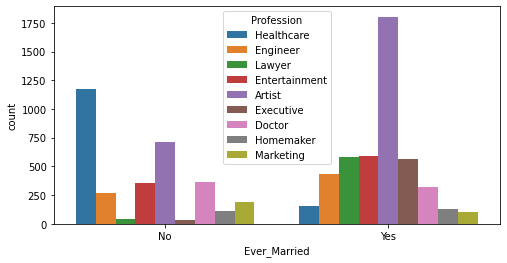

In [22]:
plt.figure(figsize=(8,4))
sns.countplot('Ever_Married', hue='Profession', data=data)

As we saw before, ever_married was strangely affected by profession.

<AxesSubplot:xlabel='Spending_Score', ylabel='count'>

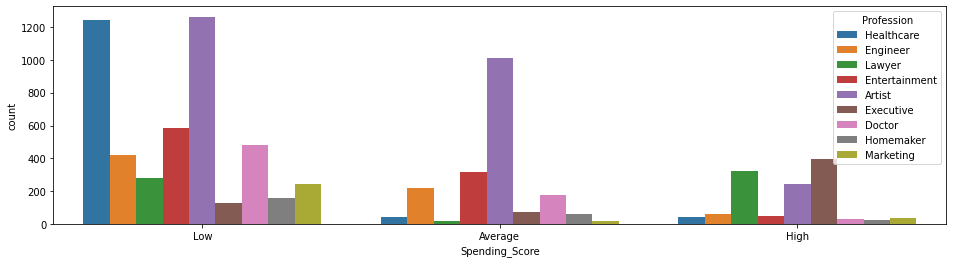

In [23]:
plt.figure(figsize=(16,4))
sns.countplot('Spending_Score', hue='Profession', data=data)

As we can see, profession and spending_score is somehow affecting each other. So, I will try to take it into consideration later on.

<AxesSubplot:xlabel='Var_1', ylabel='count'>

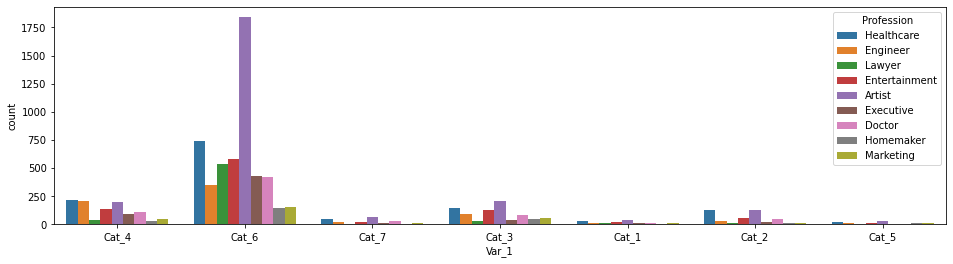

In [24]:
plt.figure(figsize=(16,4))
sns.countplot('Var_1', hue='Profession', data=data)

I don't know what 'Var_1' means, but it's obvios that we can't neglect this parameter. Now, I will try to update missing values.

In [25]:
# roughly 80% of artists have been married
profession_random = random.uniform(0,1)
data.loc[((pd.isna(data['Profession'])) 
                  & (data['Ever_Married'] == 'Yes') 
                  & (profession_random > 0.2)),
                 ['Profession']] = 'Artist'

# Low Spending_Score
# I neglected other professions and took only artists and healthcare. with equal possibilities.
low_profession = random.uniform(0,1)
data.loc[((pd.isna(data['Profession'])) 
                  & (data['Spending_Score'] == 'Low') 
                  & (low_profession > 0.5)),
                 ['Profession']] = 'Artist'

data.loc[((pd.isna(data['Profession'])) 
                  & (data['Spending_Score'] == 'Low') 
                  & (low_profession < 0.5)),
                 ['Profession']] = 'Healthcare'

# Average Spending_Score
# Artists had quite high Spending_Score
average_profession = random.uniform(0,1)
data.loc[((pd.isna(data['Profession'])) 
                  & (data['Spending_Score'] == 'Average') 
                  & (average_profession > 0.3)),
                 ['Profession']] = 'Artist'

# High Spending_Score
# I neglected other professions and took Executive and lawyer only. with equal possibilities.
high_profession = random.uniform(0,1)
data.loc[((pd.isna(data['Profession'])) 
                  & (data['Spending_Score'] == 'High') 
                  & (random.uniform(0,1) < 0.5)),
                 ['Profession']] = 'Executive'

data.loc[((pd.isna(data['Profession'])) 
                  & (data['Spending_Score'] == 'High') 
                  & (random.uniform(0,1) > 0.5)),
                 ['Profession']] = 'Lawyer'

# Var_1
data.loc[((pd.isna(data['Profession'])) 
                  & (data['Var_1'] == 'Cat_6')),
                 ['Profession']] = 'Artist'

# In case We missed any cases
data.loc[((pd.isna(data['Profession']))),
                 ['Profession']] = 'Executive'    # random choice

Let's check that it really  worked

In [26]:
print(f"Missing values in each variable: \n{data.isnull().sum()}")

Missing values in each variable: 
Gender               0
Ever_Married         0
Age                  0
Graduated            0
Profession           0
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64


4. 'Work_Experience'

<AxesSubplot:xlabel='Age', ylabel='count'>

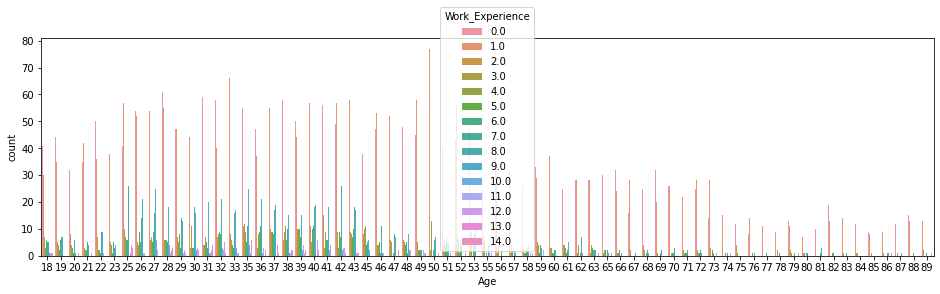

In [27]:
plt.figure(figsize=(16,4))
sns.countplot('Age', hue='Work_Experience', data=data)

I thought age and work experience was really good idea to investigate together. But I couldn't figure it out the way I wanted. It's obvious that people in their mid-ages gave approximately 5-8 years of experience, but in all ranges of age there are people with no or 1 year of work experience. I couldn't put everything together and because of that I won't consider age to update work_experience and will go on exploring other parameters.

<AxesSubplot:xlabel='Spending_Score', ylabel='count'>

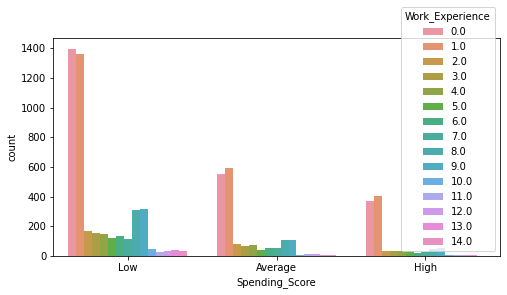

In [28]:
plt.figure(figsize=(8,4))
sns.countplot('Spending_Score', hue='Work_Experience', data=data)

people with no or very little Work_Experience tend to gave very low spending score. I will take it into consideration when updating missing values.

<AxesSubplot:xlabel='Graduated', ylabel='count'>

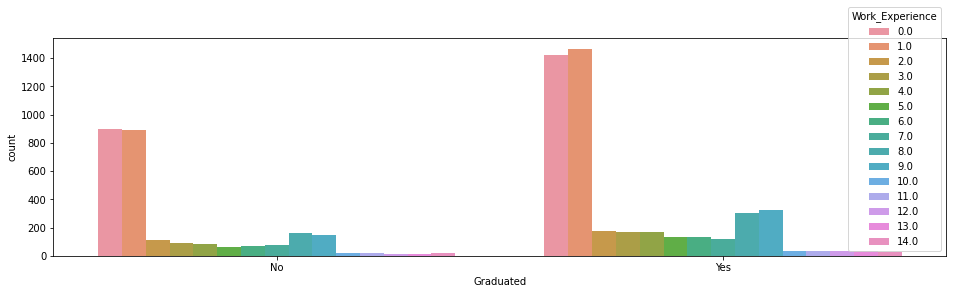

In [29]:
plt.figure(figsize=(16,4))
sns.countplot('Graduated', hue='Work_Experience', data=data)

I will take Graduated into consideration.

In [30]:
# Low Spending_Score
# It was high possibility that people with low Spending_Score had no work experience at all
data.loc[((pd.isna(data['Work_Experience'])) 
                  & (data['Spending_Score'] == 'Low')),
                 ['Work_Experience']] = 0.0

# No Graduated
# I neglected other work experience and took 0 and 1 year of experience. with equal possibilities.
work_experience_random_no_graduated = random.uniform(0,1)
data.loc[((pd.isna(data['Work_Experience'])) 
                  & (data['Graduated'] == 'No')
                 & (work_experience_random_no_graduated > 0.5)),
                 ['Work_Experience']] = 0.0

data.loc[((pd.isna(data['Work_Experience'])) 
                  & (data['Graduated'] == 'No')
                 & (work_experience_random_no_graduated < 0.5)),
                 ['Work_Experience']] = 1.0

# Yes Graduated
# I neglected other work experience and took 0 and 1 year of experience. with equal possibilities.
work_experience_random_yes_graduated = random.uniform(0,1)
data.loc[((pd.isna(data['Work_Experience'])) 
                  & (data['Graduated'] == 'Yes')
                 & (work_experience_random_yes_graduated > 0.5)),
                 ['Work_Experience']] = 0.0

data.loc[((pd.isna(data['Work_Experience'])) 
                  & (data['Graduated'] == 'Yes')
                 & (work_experience_random_yes_graduated < 0.5)),
                 ['Work_Experience']] = 1.0

Let's check that work experience has no missing values.

In [31]:
print(f"Missing values in each variable: \n{data.isnull().sum()}")

Missing values in each variable: 
Gender               0
Ever_Married         0
Age                  0
Graduated            0
Profession           0
Work_Experience      0
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64


5. 'Family_Size'

In [32]:
data['Family_Size'].describe()

count    7733.000000
mean        2.850123
std         1.531413
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         9.000000
Name: Family_Size, dtype: float64

Let's replace nan values with average number of family size

In [33]:
average_family_size = math.floor(data['Family_Size'].mean())
data['Family_Size'] = data['Family_Size'].replace(np.nan, average_family_size)

Let's check that it really did replace nan values

In [34]:
print(f"Missing values in each variable: \n{data.isnull().sum()}")

Missing values in each variable: 
Gender              0
Ever_Married        0
Age                 0
Graduated           0
Profession          0
Work_Experience     0
Spending_Score      0
Family_Size         0
Var_1              76
dtype: int64


In [35]:
data['Family_Size'].describe()

count    8068.000000
mean        2.814824
std         1.508841
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max         9.000000
Name: Family_Size, dtype: float64

We can compare initial (with nan values) and this (without nan values) and see that there was not much affected by this action. Mean was decreased insignificantly.

6. 'Var_1'

<AxesSubplot:xlabel='Work_Experience', ylabel='count'>

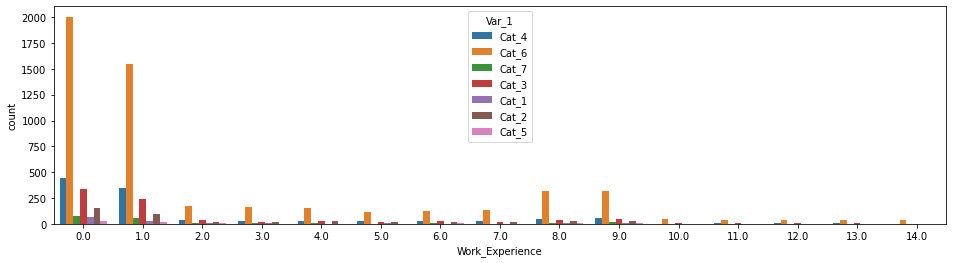

In [36]:
plt.figure(figsize=(16,4))
sns.countplot('Work_Experience', hue='Var_1', data=data)

<AxesSubplot:xlabel='Ever_Married', ylabel='count'>

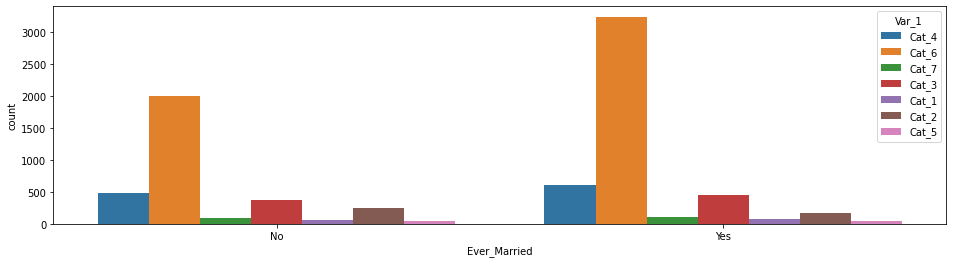

In [37]:
plt.figure(figsize=(16,4))
sns.countplot('Ever_Married', hue='Var_1', data=data)

<AxesSubplot:xlabel='Profession', ylabel='count'>

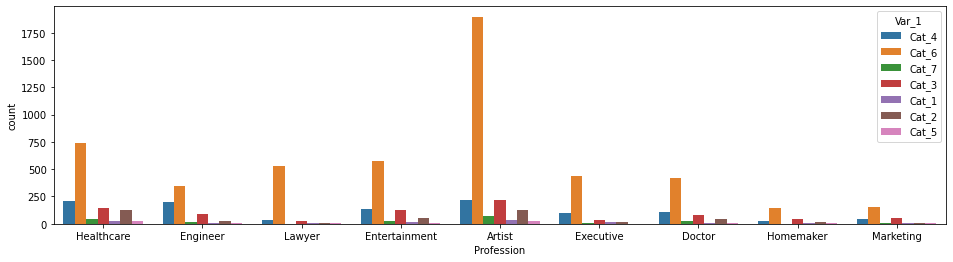

In [38]:
plt.figure(figsize=(16,4))
sns.countplot('Profession', hue='Var_1', data=data)

In [39]:
# people with one year experience had significant propabiliy of having 'Cat_6' (whatever it means)
data.loc[((pd.isna(data['Var_1'])) 
                  & (data['Work_Experience'] == 1.0)),
                 ['Var_1']] = 'Cat_6'

# I neglected other Var_1 values and took only Cat_4 and Cat_6. with corresponding probabilities.
var_random = random.uniform(0,1)
data.loc[((pd.isna(data['Var_1'])) 
                  & (data['Ever_Married'] == 'No')
                  & (var_random > 0.3)),
                 ['Var_1']] = 'Cat_6'

data.loc[((pd.isna(data['Var_1'])) 
                  & (data['Ever_Married'] == 'No')
                  & (var_random < 0.3)),
                 ['Var_1']] = 'Cat_4'

# I wanted to come up with cleverer solution to this; Wanted to investigate it with professions
# But it turned out that in every given profession they were more likely to have 'Cat_6'
data.loc[((pd.isna(data['Var_1']))),
                 ['Var_1']] = 'Cat_6'

In [40]:
print(f"Missing values in each variable: \n{data.isnull().sum()}")

Missing values in each variable: 
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64


Ok, we definetely don't have any missing values. Now we can do label encoding.

In [41]:
def mapCategoryVariables(data):
    data['Gender']         = data['Gender'].map({'Female' : 1, 'Male' : 0})
    data['Graduated']      = data['Graduated'].map({'Yes' : 1, 'No' : 0})
    data['Ever_Married']   = data['Ever_Married'].map({'Yes' : 1, 'No' : 0})
    data['Spending_Score'] = data['Spending_Score'].map({'High'     :  2,
                                                         'Average'  :  1,
                                                         'Low'      :  0})
    data['Var_1'] = data['Var_1'].map({'Cat_1'  :  1,
                                       'Cat_2'  :  2,
                                       'Cat_3'  :  3,
                                       'Cat_4'  :  4,
                                       'Cat_5'  :  5,
                                       'Cat_6'  :  6,
                                       'Cat_7'  :  7})

In [42]:
mapCategoryVariables(data)

Ok, we need one more parameter to convert. Because of the fact, that it has more than two or three unique values, I will write that funcion seperately. I will try to merge some professions, because it's better for K-means algorithm.

In [43]:
def mapProfessions(data):
    profession_map = {'Med'     : 0,
                     'Art'      : 1,
                     'Business' : 2,
                     'Other'    : 3}

    data.loc[(data['Profession'] == 'Healthcare') | (data['Profession'] == 'Doctor'), 
            ['Profession']] = 'Med'

    data.loc[(data['Profession'] == 'Artist') | (data['Profession'] == 'Entertainment'), 
            ['Profession']] = 'Art'

    data.loc[(data['Profession'] == 'Executive') | (data['Profession'] == 'Marketing'), 
            ['Profession']] = 'Business'

    data.loc[(data['Profession'] == 'Engineer')
             | (data['Profession'] == 'Lawyer')
             | (data['Profession'] == 'Homemaker'),
            ['Profession']] = 'Other'

    data['Profession'] = data['Profession'].map(profession_map)

In [44]:
mapProfessions(data)

Now, Let's quickly check that everything was converted to numeric values.

In [45]:
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,0,0,22,0,0,1.0,0,4.0,4
1,1,1,38,1,3,0.0,1,3.0,4
2,1,1,67,1,3,1.0,0,1.0,6
3,0,1,67,1,3,0.0,2,2.0,6
4,1,1,40,1,1,0.0,2,6.0,6


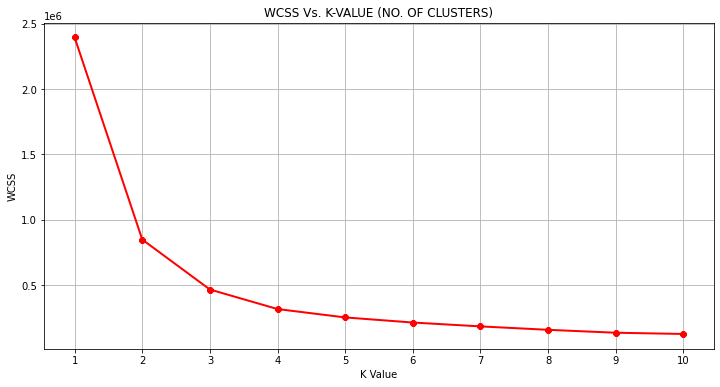

In [46]:
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(data.iloc[:,1:])
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize=(12,6))  
plt.title("WCSS Vs. K-VALUE (NO. OF CLUSTERS)")
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [47]:
pca = PCA()
pca.fit(data)


features = pd.Series(pca.components_[0], index=data.columns.values)
sorted_features = features.abs().sort_values(ascending=False)
 
top_3_feature = sorted_features[0:3].index.values
 
# print top 3 most 'influential' feature
print(features[top_3_feature])

Age                0.998219
Work_Experience   -0.035885
Profession         0.028280
dtype: float64


In [48]:
normalized_data = stats.boxcox(data['Age']) 
data['Age'] = normalized_data[0]
norm = stats.boxcox(data['Family_Size'])
data['Family_Size'] = norm[0]
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,0,0,3.404875,0,0,1.0,0,1.515561,4
1,1,1,4.077288,1,3,0.0,1,1.178789,4
2,1,1,4.799345,1,3,1.0,0,0.000000,6
3,0,1,4.799345,1,3,0.0,2,0.724511,6
4,1,1,4.141564,1,1,0.0,2,2.011561,6


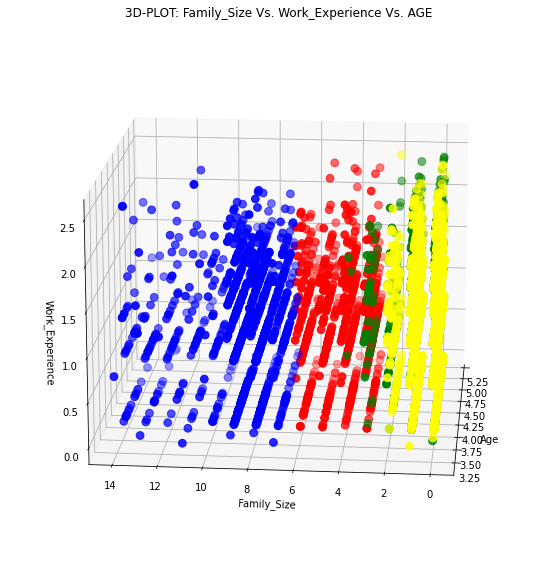

In [49]:
km = KMeans(n_clusters = 4)
clusters = km.fit_predict(data.iloc[:,1:])
data["cluster"] = clusters

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['Age'][data.cluster == 0],
           data["Work_Experience"][data.cluster == 0],
           data["Family_Size"][data.cluster == 0],
           c='blue', s=60)

ax.scatter(data['Age'][data.cluster == 1],
           data["Work_Experience"][data.cluster == 1],
           data["Family_Size"][data.cluster == 1],
           c='red', s=60)

ax.scatter(data['Age'][data.cluster == 2],
           data["Work_Experience"][data.cluster == 2],
           data["Family_Size"][data.cluster == 2],
           c='green', s=60)

ax.scatter(data['Age'][data.cluster == 3],
           data["Work_Experience"][data.cluster == 3],
           data["Family_Size"][data.cluster == 3],
           c='yellow', s=60)

ax.view_init(16, 185)
plt.title("3D-PLOT: Family_Size Vs. Work_Experience Vs. AGE")
plt.xlabel("Age")
plt.ylabel("Family_Size")
ax.set_zlabel('Work_Experience')
plt.show()

In [50]:
data=(data-data.mean())/data.std()
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,cluster
0,-0.909108,-1.197640,-1.559516,-1.279892,-1.206059,-0.412077,-0.736787,0.902239,-0.804163,-0.039135
1,1.099843,0.834872,-0.170352,0.781219,1.683040,-0.712813,0.612373,0.349766,-0.804163,-0.039135
2,1.099843,0.834872,1.321374,0.781219,1.683040,-0.412077,-0.736787,-1.584030,0.604279,0.845287
3,-0.909108,0.834872,1.321374,0.781219,1.683040,-0.712813,1.961534,-0.395474,0.604279,0.845287
4,1.099843,0.834872,-0.037562,0.781219,-0.243026,-0.712813,1.961534,1.715923,0.604279,0.845287


This clusters are based on family size.
Whether or not size is < 2, size > 2 and size < 6 or size > 6.
Now I want to compare this visualization with data, if I have not filled nan values in data. So, I will now take copy of initial data and remove all the nan values (with same reason - because K-Means can't handle them). First, check that our copied_data is for real initially given one.

In [51]:
print(f"Missing values in each variable: \n{copied_data.isnull().sum()}")

Missing values in each variable: 
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession         124
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64


Now we can remove missing variables in all columns

In [52]:
for column_name in copied_data:
    copied_data.dropna(subset = [column_name], inplace=True)

In [53]:
print(f"Missing values in each variable: \n{copied_data.isnull().sum()}")

Missing values in each variable: 
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64


Let's quickly check that we didn't erased all the data

In [54]:
copied_data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
2,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6
5,Male,Yes,56,No,Artist,0.0,Average,2.0,Cat_6
6,Male,No,32,Yes,Healthcare,1.0,Low,3.0,Cat_6


Good, now we can replace category variables with numeric values. Because we did that above I will use same function for this.

In [55]:
mapCategoryVariables(copied_data)
mapProfessions(copied_data)

Checking that it worked

In [56]:
data = copied_data
copied_data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,0,0,22,0,0,1.0,0,4.0,4
2,1,1,67,1,3,1.0,0,1.0,6
3,0,1,67,1,3,0.0,2,2.0,6
5,0,1,56,0,1,0.0,1,2.0,6
6,0,0,32,1,0,1.0,0,3.0,6


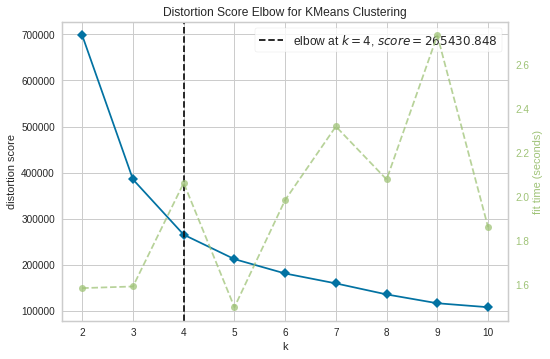

In [57]:
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer
from yellowbrick.cluster import KElbowVisualizer

visualizer = kelbow_visualizer(KMeans(random_state=10), copied_data, k=(2,11))
visualizer.show()
plt.show()

In [58]:
normalized_data = stats.boxcox(data['Age']) 
data['Age'] = normalized_data[0]
norm = stats.boxcox(data['Family_Size'])
data['Family_Size'] = norm[0]
data.head()

,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,0,0,3.497090,0,0,1.0,0,1.550591,4
2,1,1,4.979275,1,3,1.0,0,0.000000,6
3,0,1,4.979275,1,3,0.0,2,0.732702,6
5,0,1,4.731771,0,1,0.0,1,0.732702,6
6,0,0,3.981426,1,0,1.0,0,1.200185,6


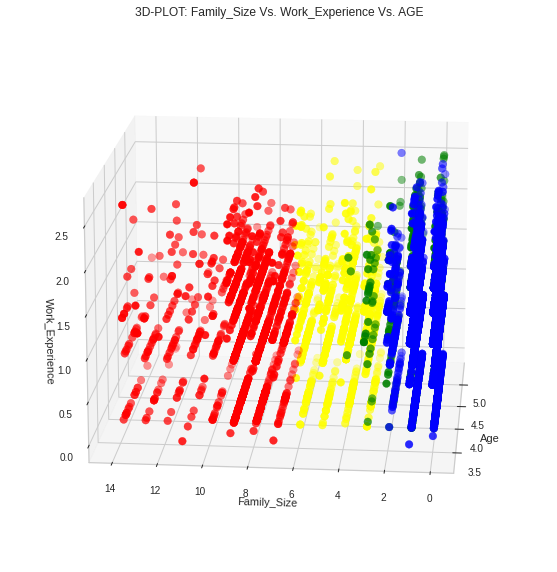

In [59]:
km = KMeans(n_clusters = 4)
clusters = km.fit_predict(copied_data.iloc[:,1:])
data["cluster"] = clusters

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data['Age'][data.cluster == 0],
           data["Work_Experience"][data.cluster == 0],
           data["Family_Size"][data.cluster == 0],
           c='blue', s=60)

ax.scatter(data['Age'][data.cluster == 1],
           data["Work_Experience"][data.cluster == 1],
           data["Family_Size"][data.cluster == 1],
           c='red', s=60)

ax.scatter(data['Age'][data.cluster == 2],
           data["Work_Experience"][data.cluster == 2],
           data["Family_Size"][data.cluster == 2],
           c='green', s=60)

ax.scatter(data['Age'][data.cluster == 3],
           data["Work_Experience"][data.cluster == 3],
           data["Family_Size"][data.cluster == 3],
           c='yellow', s=60)

ax.view_init(16, 185)
plt.title("3D-PLOT: Family_Size Vs. Work_Experience Vs. AGE")
plt.xlabel("Age")
plt.ylabel("Family_Size")
ax.set_zlabel('Work_Experience')
plt.show()

As we can see, there was not much affected by removing missing values and clusters are nearly the same, even optimal number of clusters were identical.